In [1]:
#Import Modules
import subprocess
import pandas as pd
import numpy as np
import os
from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output,State

sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

# Data Understanding
* There are different sources of Data and we have to make sure that the data is from a reliable source

#### ***1. For COVID Data***

#### From GITHUB
* Global Data for this analysis is imported from the data repository for the 2019 Novel Coronavirus operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). 

* It can either be downloaded from the command prompt using "git clone https://github.com/CSSEGISandData/COVID-19.git " or directly from Jupyter notebook

In [2]:
def git_pull(repo_path, folder_path):
    git_pull = subprocess.Popen(r'D:\Programs\anaconda3\Library\bin\git pull '  + repo_path, 
                     cwd = os.path.dirname(folder_path), 
                     shell = True, 
                     stdout = subprocess.PIPE, 
                     stderr = subprocess.PIPE )
    (out, error) = git_pull.communicate()

    print("Error : " + str(error)) 
    print("out : " + str(out))
    
git_pull_corona = git_pull('https://github.com/CSSEGISandData/COVID-19.git', r"..\data\raw\COVID-19\.git")
git_pull_corona

Error : b'From https://github.com/CSSEGISandData/COVID-19\n * branch                  HEAD       -> FETCH_HEAD\n'
out : b'Already up to date.\n'


#### ***2. For Population Data***

In [3]:
data_population = pd.read_csv('https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/world_pop_by_country.csv')
data_population = data_population.rename(columns={'Country Name':'location', '2018': 'population'}).drop(columns={'Country Code'})
data_population.head()

,location,population
0,Aruba,105845.0
1,Afghanistan,37172386.0
2,Angola,30809762.0
3,Albania,2866376.0
4,Andorra,77006.0


#### (Optional) List of Countries
* To view the list of countries in each dataset, uncomment the below cell
* If you are interested to view the trend in a different country, make sure that the country name appears same in all 3 datasets

In [4]:
#print(raw_data['Country/Region'].unique())
#print(data_population['location'].unique())

# Data Preparation
* Data which is saved in csv format is processed to remove the data which are outliers and convert into a format with which further analysis can be carried out

#### ***1. For COVID Data***

In [5]:
data_path = r"..\data\raw\COVID-19\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_confirmed_global.csv"
raw_data = pd.read_csv(data_path)

time_idx=raw_data.columns[4:]
df_plot = pd.DataFrame({
    'date':time_idx})

# Creating a list of countries which we wish to analyze
country_list=['Japan',
              'Belgium',
              'Italy']

for each in country_list:
    #df_plot['infected_'+each]=np.array(raw_data[raw_data['Country/Region']==each].iloc[:,4::].sum(axis=0).div(float(data_population.loc[data_population['location'] == each, 'population'])).round(4))
    df_plot[each]=np.array(raw_data[raw_data['Country/Region']==each].iloc[:,4::].sum(axis=0))
    
time_idx=[datetime.strptime(each,"%m/%d/%y") for each in df_plot.date] # convert to datetime
time_str=[each.strftime('%Y-%m-%d') for each in time_idx] # convert back to date ISO norm (str)
df_plot['date']=time_idx

#Saving the edited raw data to processed folder
df_plot.to_csv('../data/processed/COVID_small_flat_table.csv',sep=';',index=False)

#Displaying the last 5 Values of the processed Dataframe
df_plot.tail()
df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True)
df_analyse

,date,Japan,Belgium,Italy
0,2020-01-22,2,0,0
1,2020-01-23,2,0,0
2,2020-01-24,2,0,0
3,2020-01-25,2,0,0
4,2020-01-26,4,0,0
...,...,...,...,...
912,2022-07-22,10995193,4381331,20539016
913,2022-07-23,11196063,4381331,20608190
914,2022-07-24,11372555,4381331,20660065
915,2022-07-25,11499018,4398161,20684182


In [6]:
#N0 = float(data_population.loc[data_population['location'] == 'Italy', 'population'])
N0=1000000
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate

I0=df_analyse.Italy[30]
S0=N0-I0
R0=0

In [7]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

## Simulative approach to calculate SIR curves

In [8]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

C:\Users\harib\AppData\Local\Temp\ipykernel_14852\3252408798.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propagation_rates=propagation_rates.append({'susceptible':SIR[0],
C:\Users\harib\AppData\Local\Temp\ipykernel_14852\3252408798.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propagation_rates=propagation_rates.append({'susceptible':SIR[0],
C:\Users\harib\AppData\Local\Temp\ipykernel_14852\3252408798.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propagation_rates=propagation_rates.append({'susceptible':SIR[0],
C:\Users\harib\AppData\Local\Temp\ipykernel_14852\3252408798.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

C:\Users\harib\AppData\Local\Temp\ipykernel_14852\3252408798.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propagation_rates=propagation_rates.append({'susceptible':SIR[0],
C:\Users\harib\AppData\Local\Temp\ipykernel_14852\3252408798.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propagation_rates=propagation_rates.append({'susceptible':SIR[0],
C:\Users\harib\AppData\Local\Temp\ipykernel_14852\3252408798.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propagation_rates=propagation_rates.append({'susceptible':SIR[0],
C:\Users\harib\AppData\Local\Temp\ipykernel_14852\3252408798.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

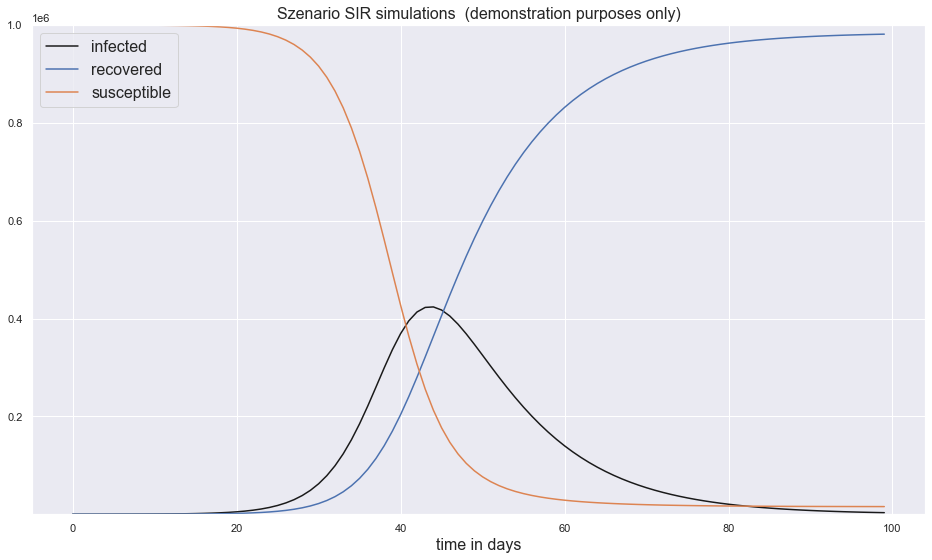

In [9]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

## Fitting data to a model
* Goal is to fit a data model (SIR) model to obtain the parameters beta and gamma
 -  step one: always start on simulative / constructive data 
 -  step two: cross check if the innerlogic of your parameter fitting is correct

In [10]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [11]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [12]:
## fit the data set ydata, here the simulative data set of the infected curve

ydata = propagation_rates.infected
t=np.arange(len(ydata))

In [13]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

C:\Users\harib\AppData\Local\Temp\ipykernel_14852\649699423.py:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
C:\Users\harib\AppData\Local\Temp\ipykernel_14852\649699423.py:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
D:\Programs\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\harib\AppData\Local\Temp\ipykernel_14852\649699423.py:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I


standard deviation errors :  [0.00086909 0.00074193]  start infect: 25.99984
Optimal parameters: beta = 0.37329719386975296  and gamma =  0.0961934476058794


In [14]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

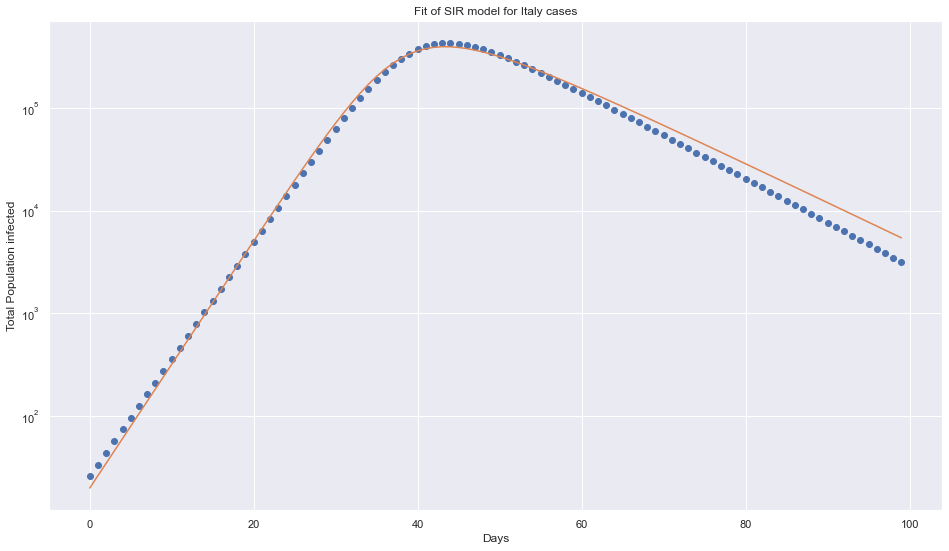

Optimal parameters: beta = 0.37329719386975296  and gamma =  0.0961934476058794
Basic Reproduction Number R0  3.8806925332296416


In [15]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
#plt.semilogy(fitted)

plt.title("Fit of SIR model for Italy cases")
plt.ylabel("Total Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])

##  Dynamic Dashboard for SIR model

In [16]:
data_path = r"..\data\raw\COVID-19\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_confirmed_global.csv"
pd_raw = pd.read_csv(data_path)

In [17]:
country_list=['Japan', 'Belgium', 'Italy', 'Germany',
              'Poland','Canada']
date=pd_raw.columns[4:]
df_analyse=pd.DataFrame({'Date':date})

for each in country_list:
    df_analyse[each] = np.array(pd_raw[pd_raw['Country/Region']==each].iloc[:,4::].sum(axis=0)).T

df_analyse.to_csv('../data/raw/COVID-19/csse_covid_19_data/SIR.csv',index=False)

In [18]:
N0=1000000 #max susceptible population as shown in the lecture taken random
beta=0.4   # infection spread dynamic
gamma=0.1  # recovery rate

df_data_=df_analyse[40:140]
t=np.arange(df_data_.shape[0])

R0=0

df_data = df_data_.drop(['Date'], axis=1).diff().fillna(0)
df_data.insert(0,'Date', df_data_['Date'])

for country in country_list:
    y_data=np.array(df_data[df_data[country]>0][country])
    t=np.arange(len(y_data))

    I0=y_data[0]
    S0=N0-I0
    popt=[0.4,0.1]
    fit_odeint(t, *popt)
    popt, pcov = optimize.curve_fit(fit_odeint, t, y_data, maxfev=5000)
    perr = np.sqrt(np.diag(pcov))
    fitted=fit_odeint(t, *popt)
    fitted_pad = np.concatenate((np.zeros(df_data.shape[0]-len(fitted)) ,fitted))
    df_data[country + '_fitted'] = fitted_pad

df_data = df_data.reset_index(drop=True)
df_data.to_csv('../data/processed/SIR_fitted_curve.csv')

In [ ]:
fig = go.Figure()
app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    #  SIR Model Dashboard
    * The first plot shows the new cases with time.
    * The second plot shows the SIR Model 
    
    '''),

    dcc.Markdown('''
    ## Select Country
    '''),
    dcc.Dropdown(
        id='country_drop_down',
        options=[ {'label': each,'value':each} for each in country_list],
        value=['Japan','Canada', 'Italy'], # which are pre-selected
        multi=True),
    dcc.Graph(figure=fig, id='main_window_slope')])


@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value')])
def update_figure(country_list):
    v = 0
    my_yaxis={'type':"log",'title':'Confirmed'}
    traces = []
    for each in country_list:
        traces.append(dict(x=df_data['Date'],y=df_data[each][1:],
                                mode='line',name=each))
        traces.append(dict(x=df_data['Date'],
                                y=df_data[each+'_fitted'][2:],
                                mode='lines+markers',name=each+'_simulated'))

        v = v+1
    return {
            'data': traces,
            'layout': dict (
                width=1280,height=720,
                xaxis={'title':'Time','tickangle':-45,'nticks':20,
                'tickfont':dict(size=14,color="#0c6887"),},yaxis=my_yaxis)}

if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [ ]:
#from scipy.signal import savgol_filter

#savgol_filter(xy, 5, 2)